# Colour - HDRI - Examples: Merge from Low Dynamic Range Files

Through this example, some Canon EOS 5D Mark II *CR2* files converted to low dynamic range *sRGB* colourspace *Tiff* files will be merged together in order to create a single radiance image.

The following steps will be taken:

- Conversion of the *CR2* files to low dynamic range *sRGB* colourspace *Tiff* files using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- Creation of a camera response functions computation dedicated image stack using cherry picked *Tiff* files. The two files with lowest luminance are discarded as their contribution is biasing the resulting camera response functions.
    - Reading of the *Tiff* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
- Computation of the camera response functions.
- Creation of an image stack using *Tiff* files.
- Merging of the image stack into a radiance image using the camera response functions.
- Display of the final resulting radiance image.

In [1]:
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import shlex
import subprocess

import colour

from colour_hdri import (
    EXAMPLES_RESOURCES_DIRECTORY,
    ImageStack,
    camera_response_functions_Debevec1997,
    filter_files,
    image_stack_to_radiance_image,
    weighting_function_Debevec1997)
from colour_hdri.plotting import plot_radiance_image_strip

logging.basicConfig(level=logging.INFO)

RESOURCES_DIRECTORY = os.path.join(EXAMPLES_RESOURCES_DIRECTORY,
                                   'frobisher_001')

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.9.9 (main, Nov 21 2021, 03:16:13)                          *
*                [Clang 13.0.0 (clang-1300.0.29.3)]                           *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.1                                                        *
*       colour-hdri : v0.1.8-100-g8c61166                                     *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.16.0                                                      *
*       matplotlib : 3.4.3                                                    *
*       numpy : 1.22.2                  

## CR2 Files Conversion to Tiff Files¶

In [2]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

for path in RAW_FILES:
    logging.info('Converting "{0}" to "Tiff" file...'.format(path))
    subprocess.call(['dcraw'] + shlex.split('-w -W -H 0 -q 3 -T "{0}"'.format(path)))

TIFF_FILES = sorted(glob.glob('{0}/*.tiff'.format(RESOURCES_DIRECTORY)))

INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2" to "Tiff" file...
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2" to "Tiff" file...
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.CR2" to "Tiff" file...
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.CR2" to "Tiff" file...
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2602.CR2" to "Tiff" file...


## Camera Response Functions Computation

INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.tiff" image.
/Users/kelsolaar/Library/Caches/pypoetry/virtualenvs/colour-hdri-bkoxrqd3-py3.9/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.tiff" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.tiff' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.tiff" image.
/Users/kelsolaar/Library/C

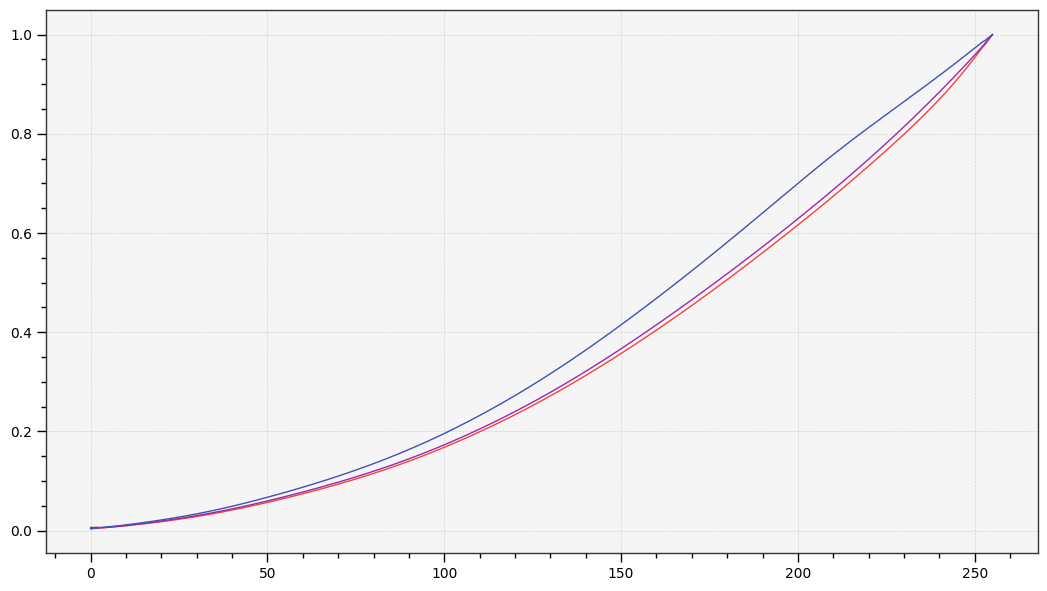

In [3]:
CRFS = camera_response_functions_Debevec1997(
    ImageStack.from_files(TIFF_FILES[2:5]), l_s=100)

CRFS = CRFS[np.all(CRFS, axis=1)]

plt.plot(CRFS)
plt.show();

## Radiance Image Merge

In [4]:
def merge_from_ldr_files(
        ldr_files,
        output_directory,
        camera_response_functions,
        batch_size=5):
    paths = []
    for ldr_files in colour.utilities.batch(ldr_files, batch_size):
        image_stack = ImageStack.from_files(ldr_files)

        path = os.path.join(
            output_directory,
            '{0}_{1}_MLF.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))
        paths.append(path)
        
        logging.info('Merging "{0}"...'.format(path))
        logging.info('\tImage stack "F Number" (Exif): {0}'.format(
            image_stack.f_number))
        logging.info('\tImage stack "Exposure Time" (Exif): {0}'.format(
            image_stack.exposure_time))
        logging.info('\tImage stack "ISO" (Exif): {0}'.format(
            image_stack.iso))
        image = image_stack_to_radiance_image(
            image_stack, camera_response_functions=camera_response_functions)

        logging.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

    return paths

PATHS = merge_from_ldr_files(
    TIFF_FILES, RESOURCES_DIRECTORY, CRFS)

INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.tiff" image.
/Users/kelsolaar/Library/Caches/pypoetry/virtualenvs/colour-hdri-bkoxrqd3-py3.9/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.tiff" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.tiff' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.tiff" image.
/Users/kelsolaar/Library/C

## Radiance Image Display

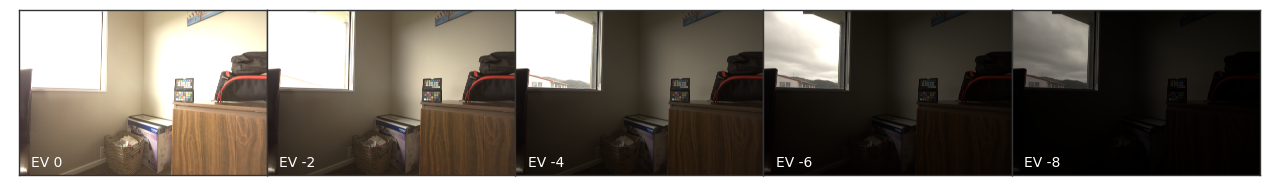

In [5]:
plot_radiance_image_strip(colour.read_image(PATHS[0]));